In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from geopy.geocoders import Nominatim
! pip install folium
import folium
! pip install pygeocoder
from pygeocoder import Geocoder
! pip install shapely
import urllib.request, json 
from shapely.geometry import Point, Polygon

print('Packages installed')

     |████████████████████████████████| 92kB 17.3MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/7c/4c/00/d05c66c4af5411c554c91b8079732c8a0359c2226fb8c01031
Successfully built pygeocoder
     |████████████████████████████████| 1.5MB 16.0MB/s eta 0:00:01
Packages installed


# A lot of data cleaning and scraping was done not in notebook, so in order to show that it was done by me, I will import my python code from pycharm IDE as a text <br>
- **Scraper for companies coords** :
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup
import time
import random
import logging
from test_stuff import fix_name
import urllib


class data_mine:

    def __init__(self, web_page):
        # Webpage html, that is going to be data mined.
        self.web_page = web_page

    def mine(self):
        names = fix_name
        # Creates file, to store all the scraped data
        filename = 'enterprise.csv'
        # utf-16 for lithuanian, but using it messes up column separation in CSV
        # utf-8 for ENG
        f = open(filename, "w", encoding="utf-16")
        titles = 'Name,Address\n'  # CSV file column names.
        f.write(titles)
        for index, name in enumerate(names):
            try:
                addresses = {}
                url = "%s"%(self.web_page) + "%s" %(urllib.request.quote(name))
                uClient = uReq(url)
                main_page_html = uClient
                page_soup = soup(main_page_html, 'html.parser')
                # Grabs all the data that certain container has.
                spans = page_soup.findAll("span", {"itemprop": "streetAddress"})
                if spans != []:
                    adresas = spans[0].text
                    addresses[name] = adresas
                else:
                    addresses[name] = 'No info'
                # Write all data  to csv
                f.write('%s,%s\n'
                        % (name,addresses[name],)
                        )
                print(index, 'Succesfully written to csv')
            except Exception as e:
                logging.error("Exception occurred", exc_info=True)
        f.close()

test_1 = data_mine("https://www.1551.lt/paieska/?keyword=")
test_1.mine()

- **Scraper for housing listings**:
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup
from time import time

class data_mine:

    def __init__(self, web_page):
        # Webpage html, that is going to be data mined.
        self.web_page = web_page

    def mine(self):
        # That's the number of pages we are gonna scrape thru. Need to find better way.
        page_num = 128
        # Looped
        items_looped = []
        # Creates file, to store all the scraped data
        filename = 'flats.csv'
        # utf-16 for lithuanian, but using it messes up column separation in CSV
        # utf-8 for ENG
        f = open(filename, "w", encoding="utf-8")
        headers = 'Adresas , Rajonas, Kambarių sk, Plotas, Kaina, Šildymas, Pastato tipas, Metai\n'  # CSV file column names.
        f.write(headers)
        for i in range(page_num):
            # Gonna calculate how much time, is it gonna take to loop thru 1 page
            start_time = time()
            # Main pages URL
            main_url = "%s/%s" %(self.web_page, i)
            uClient = uReq(main_url)
            main_page_html = uClient

            # Parses all of the data that particular html has
            page_soup = soup(main_page_html, 'html.parser')

            # Grabs all the data that certain container has.
            containers = page_soup.findAll("tr", {"class": "list-row"})

            # Loops thru pages designated container and gets required data.
            for container in containers:
                try:
                    flat_href = container.a['href']
                    flat_title = container.a.img['alt']
                    new_lookup_url = 'https://www.aruodas.lt/{0}'.format(flat_href)
                    new_lookup_page_html = uReq(new_lookup_url)
                    # Parses all of the data that particular new look html has
                    new_lookup_page_soup = soup(new_lookup_page_html, 'html.parser')
                    # Parses flat's price from html.
                    flat_price = new_lookup_page_soup.findAll('span', {'class': "price-eur"})[0].text.replace(" ", "")
                    flat_price = float(flat_price[:-1])
                    # Flats adress and neighbourhood
                    flat_adress = flat_title.split(",")[1]
                    flat_neighbourhood = flat_title.split(",")[0]
                    # Empty lists, needed to create flat's detail dictionary.
                    dt_tag_list = []
                    dd_tag_list = []
                    # Looping thru container that has all of the detail names.
                    # These are gonna be key's inside our details dictionary.
                    for dt_tag in new_lookup_page_soup.findAll('dt'):
                        flat_details_raw_text_dt = dt_tag.text.replace(' ', "").replace('\n', "").replace(':',
                                                                                                          "").replace(
                            '.',
                            "")
                        dt_tag_list.append(flat_details_raw_text_dt)
                    # Looping thru container that has all of the detail values.
                    # These are gonna be values inside our details dictionary.
                    for dd_tag in new_lookup_page_soup.findAll('dd'):
                        flat_details_raw_text_dd = dd_tag.text.replace(' ', "").replace('\n', "").replace(',', '.')
                        dd_tag_list.append(flat_details_raw_text_dd)
                    # Zips generated new lists of detail names and values to dictionary.
                    flat_details_dict = dict(zip(dt_tag_list, dd_tag_list))
                    # Writing to CSV file
                    f.write(
                        flat_adress + "," +
                        flat_neighbourhood + "," +
                        flat_details_dict['Kambariųsk'] + "," +
                        flat_details_dict['Plotas'][:-2] + "," +
                        str(flat_price) + "," +
                        flat_details_dict['Šildymas'] + "," +
                        flat_details_dict['Pastatotipas'] + "," +
                        flat_details_dict['Metai'] + "," +
                        "\n")

                    # Time it takes to loop
                    end_time = time()
                    total_time = end_time - start_time
                    # Items alredy looped
                    items_looped.append("Succes")
                    print('%s advertisment succesfully written to CSV' % len(items_looped))
                except:
                    print('Error occurred, skiping to other advertisment')
            print("It took %s seconds to loop %s page" % (total_time, i))
        f.close()





In [2]:
# Real estate data
sheet_url_RD = 'https://docs.google.com/spreadsheets/d/1CiUj-cWcO1D7KN_qfs6jArjfHf9njpUGlrc3Lk2GxO0/edit#gid=915412023'
csv_export_url_RD = sheet_url_RD.replace('/edit#gid=', '/export?format=csv&gid=')
aruodas_df = pd.read_csv(csv_export_url_RD)
aruodas_df.rename(columns={'Adresas': 'Adress',
                     'Rajonas':'Neighbourhood',
                     'Plotas':'Area',
                     'Kaina':'Price',
                     'Metai': 'Year',
                     'Šildymas': 'Heating',
                     'Kambarių sk': 'Rooms',
                     'Pastato tipas':'Type'}, inplace=True)
#Size of the dataframe
print(aruodas_df.shape)
aruodas_df = aruodas_df.dropna()
print(aruodas_df.shape)

(3684, 11)
(3683, 11)


In [3]:
# DataFrame for housing prices based on current market in aruodas.lt advertisments.
# Data has been cleaned after all websraping.
aruodas_df.head()

,name,Adress,Neighbourhood,Rooms,Area,Price,Heating,Type,Year,latitude,longitude
0,Elbingo g.Pilaitė1,Elbingo g.,Pilaitė,1,64.0,87000,Centriniskolektorinis,Mūrinis,2018,54.70807,25.17026
1,Elbingo g.Pilaitė3,Elbingo g.,Pilaitė,3,55.0,76000,Centriniskolektorinis,Mūrinis,2018,54.70807,25.17026
2,Elbingo g.Pilaitė2,Elbingo g.,Pilaitė,2,48.0,69000,Centriniskolektorinis,Mūrinis,2018,54.70807,25.17026
3,Elbingo g.Pilaitė2,Elbingo g.,Pilaitė,2,48.0,86000,Centriniskolektorinis,Mūrinis,2018,54.70807,25.17026
4,Žaliųjų Ežerų g.Santariškės2,Žaliųjų Ežerų g.,Santariškės,2,51.5,88000,Centrinis,Mūrinis,1982statyba.2017renovacija,54.75269,25.27912


In [4]:
# Companies in Vilnius data
sheet_url_ED = 'https://docs.google.com/spreadsheets/d/1j4hwuWKW3pnJfG9qdLoxSo8QU7V07HACyH11Y3SeXGw/edit#gid=550410933'
csv_export_url_ED = sheet_url_ED.replace('/edit#gid=', '/export?format=csv&gid=')
enterprise_df = pd.read_csv(csv_export_url_ED)
enterprise_df = enterprise_df.dropna()
enterprise_df.shape

(11341, 8)

In [5]:
#Quick look at our data for companies
enterprise_df.head()

,ID,name,avgWage,numInsured,tax,address,latitude,longitude
0,63287,UAB LABBIS,2183.85,53,26969.73,Žalgirio g. 92-301 LT-09303 VILNIUS,54.703743,25.276711
1,56132,UAB KOMPONENTAS,1317.62,5,1488.08,Kapsų g. 19 LT-02166 VILNIUS,54.660313,25.284592
2,57061,UAB ELTEL NETWORKS,1484.78,247,85636.92,Vilkpėdės g. 4 LT-03151 VILNIUS,54.664582,25.247461
3,56147,UAB IDW,1432.50,225,74027.54,Dariaus ir Girėno g. 65 A LT-02189 VILNIUS,54.646482,25.270569
4,59094,UAB KONICA MINOLTA BALTIA,2194.15,54,26969.69,J. Jasinskio g. 16 LT-01112 VILNIUS,54.688118,25.261523


In [6]:
# Data set containing GeoJson polygon points for municipalities in Vilnius
# Our having all our data points, sorted in municipalities will give us a better understanding and easier management of data.
sheet_url_MD = 'https://docs.google.com/spreadsheets/d/1aELRC65_N_WrufdIjQYlQSxN87wnsl8IufOzn76qJGA/edit#gid=1220023145'
csv_export_url_MD = sheet_url_MD.replace('/edit#gid=', '/export?format=csv&gid=')
municipalities_df = pd.read_csv(csv_export_url_MD)
municipalities_df.shape

(21, 2)

In [7]:
#Quick look at our data for municipalities_df
municipalities_df.head(10)

,Municipality,JsonPoly
0,Antakalnis,https://global.mapit.mysociety.org/area/112195...
1,Fabijoniškės,https://global.mapit.mysociety.org/area/112187...
2,Grigiškės,https://global.mapit.mysociety.org/area/112159...
3,Justiniškės,https://global.mapit.mysociety.org/area/112186...
4,Karoliniškės,https://global.mapit.mysociety.org/area/112177...
5,Lazdynai,https://global.mapit.mysociety.org/area/112160...
6,Naujamiestis,https://global.mapit.mysociety.org/area/118468...
7,Naujininkai,https://global.mapit.mysociety.org/area/112196...
8,Naujoji Vilnia,https://global.mapit.mysociety.org/area/112196...
9,Paneriai,https://global.mapit.mysociety.org/area/112159...


In [8]:
# In next step I am going to create polygons representing municipalities out of parsed json data
json_list = municipalities_df['JsonPoly'].to_list()
poly_list = []

for i in json_list:
    with urllib.request.urlopen(i) as url:
        data = json.load(url)
        points = [(j[0], j[1]) for j in data['coordinates'][0]]
        polygon = Polygon(points)
        poly_list.append(polygon)



In [9]:
# Inserting newly made shapely polygons to dataframe
municipalities_df.insert(2, "ShapelyPolyObj", poly_list, True)
municipalities_df.head(10)

,Municipality,JsonPoly,ShapelyPolyObj
0,Antakalnis,https://global.mapit.mysociety.org/area/112195...,"POLYGON ((25.4256197 54.7298686, 25.4253218 54..."
1,Fabijoniškės,https://global.mapit.mysociety.org/area/112187...,"POLYGON ((25.2143712 54.7502259, 25.2145271 54..."
2,Grigiškės,https://global.mapit.mysociety.org/area/112159...,"POLYGON ((25.1098852 54.6638582, 25.1002898 54..."
3,Justiniškės,https://global.mapit.mysociety.org/area/112186...,"POLYGON ((25.1990125 54.7130838, 25.199211 54...."
4,Karoliniškės,https://global.mapit.mysociety.org/area/112177...,"POLYGON ((25.2257631 54.6995595, 25.2264139 54..."
5,Lazdynai,https://global.mapit.mysociety.org/area/112160...,"POLYGON ((25.1918925 54.6830475, 25.1895424 54..."
6,Naujamiestis,https://global.mapit.mysociety.org/area/118468...,"POLYGON ((25.2866943 54.6694587, 25.2861705 54..."
7,Naujininkai,https://global.mapit.mysociety.org/area/112196...,"POLYGON ((25.313623 54.5992503, 25.3116733 54...."
8,Naujoji Vilnia,https://global.mapit.mysociety.org/area/112196...,"POLYGON ((25.4579355 54.6874558, 25.4588796 54..."
9,Paneriai,https://global.mapit.mysociety.org/area/112159...,"POLYGON ((25.2028753 54.6356714, 25.2048006 54..."


In [10]:
# Now I need to check if my enterprise_df and aruodas_df coord points are within any of these polies.
# If so, I want them to return dictionaries for both of dataframes, containing Name(enterprise or housing) and Municipality
import geopy.distance

def check_points(df1,df2):
    vilnius_city_center = (54.687157,25.279652)
    temp_dict1 = {}
    temp_dict2 = {}
    for i in zip(df1['longitude'].to_list(), df1['latitude'].to_list(),df1['name'].to_list()):
        point = Point(i[0],i[1])
        dist_point = (i[1],i[0])    
        dist = geopy.distance.distance(vilnius_city_center, dist_point).kilometers
        for j in zip(df2['Municipality'].to_list(), df2['ShapelyPolyObj'].to_list()):
            if j[1].contains(point):
                temp_dict1[i[2]] = j[0]
                temp_dict2[i[2]] = dist
    temp_df1 = pd.DataFrame(list(temp_dict1.items()), columns=['name', 'municipality'])
    temp_df2 = pd.DataFrame(list(temp_dict2.items()), columns=['name', 'distance'])
    return pd.merge(temp_df1, temp_df2, on='name')

In [11]:
enterprise_check = check_points(enterprise_df, municipalities_df)
aruodas_check = check_points(aruodas_df, municipalities_df)

In [12]:
# Adding newly parsed municipalities to main dataframes.
aruodas_df = pd.merge(aruodas_df, aruodas_check, on='name')
enterprise_df = pd.merge(enterprise_df, enterprise_check, on='name')

In [64]:
enterprise_df.head()

,ID,name,avgWage,numInsured,tax,address,latitude,longitude,municipality,distance,Clus_Db
0,63287,UAB LABBIS,2183.85,53,26969.73,Žalgirio g. 92-301 LT-09303 VILNIUS,54.703743,25.276711,Šnipiškės,1.856076,-1
1,56132,UAB KOMPONENTAS,1317.62,5,1488.08,Kapsų g. 19 LT-02166 VILNIUS,54.660313,25.284592,Naujininkai,3.005142,-1
2,57061,UAB ELTEL NETWORKS,1484.78,247,85636.92,Vilkpėdės g. 4 LT-03151 VILNIUS,54.664582,25.247461,Vilkpėdė,3.259979,-1
3,56147,UAB IDW,1432.50,225,74027.54,Dariaus ir Girėno g. 65 A LT-02189 VILNIUS,54.646482,25.270569,Naujininkai,4.565653,-1
4,59094,UAB KONICA MINOLTA BALTIA,2194.15,54,26969.69,J. Jasinskio g. 16 LT-01112 VILNIUS,54.688118,25.261523,Naujamiestis,1.174031,0


In [65]:
enterprise_df.shape

(11329, 11)

In [14]:
aruodas_df.head()

,name,Adress,Neighbourhood,Rooms,Area,Price,Heating,Type,Year,latitude,longitude,municipality,distance
0,Elbingo g.Pilaitė1,Elbingo g.,Pilaitė,1,64.0,87000,Centriniskolektorinis,Mūrinis,2018,54.70807,25.17026,Pilaitė,7.427265
1,Elbingo g.Pilaitė1,Elbingo g.,Pilaitė,1,64.0,87000,Centriniskolektorinis,Mūrinis,2018,54.70807,25.17026,Pilaitė,7.427265
2,Elbingo g.Pilaitė3,Elbingo g.,Pilaitė,3,55.0,76000,Centriniskolektorinis,Mūrinis,2018,54.70807,25.17026,Pilaitė,7.427265
3,Elbingo g.Pilaitė3,Elbingo g.,Pilaitė,3,55.0,76000,Centriniskolektorinis,Mūrinis,2018,54.70807,25.17026,Pilaitė,7.427265
4,Elbingo g.Pilaitė2,Elbingo g.,Pilaitė,2,48.0,69000,Centriniskolektorinis,Mūrinis,2018,54.70807,25.17026,Pilaitė,7.427265


In [66]:
aruodas_df.shape

(3658, 13)

## Data analysis chapter

In [15]:
aruodas_df[['distance','Area','Rooms','Price']].corr()

,distance,Area,Rooms,Price
distance,1.000000,-0.153701,-0.097054,-0.356893
Area,-0.153701,1.000000,0.797671,0.784463
Rooms,-0.097054,0.797671,1.000000,0.536590
Price,-0.356893,0.784463,0.536590,1.000000


(0, 1945727.5550145197)

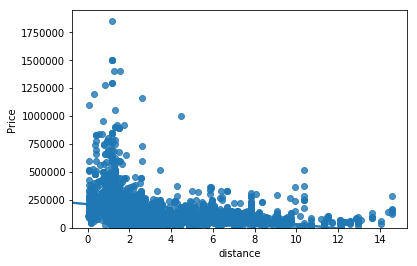

In [16]:
sns.regplot(x="distance", y="Price", data=aruodas_df)
plt.ylim(0,)

(0, 1946497.287314728)

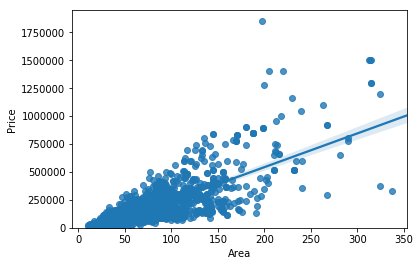

In [17]:
sns.regplot(x="Area", y="Price", data=aruodas_df)
plt.ylim(0,)

In [18]:
# Vilniu city geojson
vilnius_geo = json.load(urllib.request.urlopen('http://gis-vplanas.opendata.arcgis.com/datasets/6d5088b44dba4643a6611455d5352268_1.geojson'))
vilnius_geo

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'OBJECTID': 1,
    'NR': 15,
    'SENIUNIJA': 'Rasos',
    'SHAPEarea': 16230362.344606875,
    'SHAPElen': 29906.439954261037},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[25.331842014649958, 54.69412637237561],
      [25.330620770512926, 54.694372784964756],
      [25.330033238899816, 54.69454328310434],
      [25.32950004525396, 54.694681086934956],
      [25.327519702637513, 54.695124805799836],
      [25.32695281472544, 54.69523681401808],
      [25.32668251589788, 54.69538123464445],
      [25.326400217505277, 54.695598302001954],
      [25.326172545922866, 54.69574675682202],
      [25.324671820378946, 54.69478190592213],
      [25.323715689426184, 54.69425978991003],
      [25.322404783258687, 54.69353041413871],
      [25.32101655971858, 54.69270758518664],
      [25.320854551645965, 54.692593023375764],
      [25.320132062155352, 54.69208212031256],
      [25.319788068422543, 54.691

In [19]:
# Plain vilnius city map
vilnius_city_center = (54.687157,25.279652)
enterprise_map = folium.Map(location=[vilnius_city_center[0], vilnius_city_center[1]], zoom_start=11)

In [20]:
grouped_wage = enterprise_df[['avgWage','municipality']].groupby('municipality').mean()
grouped_wage = grouped_wage.reset_index()

In [21]:
# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(grouped_wage['avgWage'].min(),
                              grouped_wage['avgWage'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

# Choropleth map of average wages in Vilnius, based on municipalities.
enterprise_map.choropleth(
    geo_data=vilnius_geo,
    data=grouped_wage,
    columns=['municipality', 'avgWage'],
    key_on='feature.properties.SENIUNIJA',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average salary',
    threshold_scale=threshold_scale,
    reset=True
)

# display map
enterprise_map

/opt/conda/envs/Python36/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [22]:
# Plain vilnius city map
vilnius_city_center = (54.687157,25.279652)
aruodas_map = folium.Map(location=[vilnius_city_center[0], vilnius_city_center[1]], zoom_start=11)

In [23]:
grouped_estates = aruodas_df[['Price','municipality']].groupby('municipality').mean()
grouped_estates = grouped_estates.sort_values(by=['Price']).reset_index()
grouped_estates

,municipality,Price
0,Grigiškės,43611.566667
1,Paneriai,49450.000000
2,Naujoji Vilnia,60618.125984
3,Naujininkai,61114.193548
4,Vilkpėdė,63337.109589
5,Karoliniškės,67379.214286
6,Viršuliškės,70849.864865
7,Justiniškės,75052.163934
8,Pašilaičiai,75521.561453
9,Šeškinė,75859.966102


In [24]:
# Choropleth map of average wages in Vilnius, based on municipalities.
aruodas_map.choropleth(
    geo_data=vilnius_geo,
    data=grouped_estates,
    columns=['municipality', 'Price'],
    key_on='feature.properties.SENIUNIJA',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Price of housing',
)

# display map
aruodas_map

# Analysis of real estate listings.

Goal of this section is to create a multilinear model, that could best predict apartments price on selected variables.

In [25]:
# Defining our linear regression.
lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [26]:
Z = aruodas_df[['Rooms','distance','Area']]

In [27]:
lm.fit(Z, aruodas_df['Price'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [28]:
Y_hat = lm.predict(Z)
print('The R-square is: ', lm.score(Z, aruodas_df['Price']))

The R-square is:  0.6915419832954146


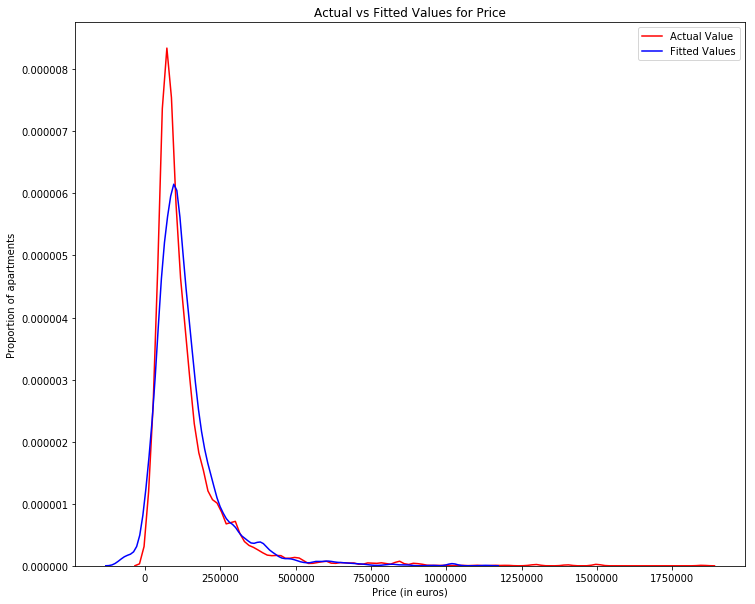

In [29]:
# Visualizing how our model turned out to work.
width = 12
height = 10

plt.figure(figsize=(width, height))

ax1 = sns.distplot(aruodas_df['Price'], hist=False, color="r", label="Actual Value")
sns.distplot(Y_hat, hist=False, color="b", label="Fitted Values" , ax=ax1)


plt.title('Actual vs Fitted Values for Price')
plt.xlabel('Price (in euros)')
plt.ylabel('Proportion of apartments')

plt.show()
plt.close()

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
y_data = aruodas_df['Price']
x_data = aruodas_df[['Rooms','distance','Area']]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=1)


print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples : 549
number of training samples: 3109


In [32]:
lre=LinearRegression()
lre.fit(x_train[['Rooms','distance','Area']], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [33]:
lre.score(x_test[['Rooms','distance','Area']], y_test)

0.6772354635968805

In [34]:
lre.score(x_train[['Rooms','distance','Area']], y_train)

0.6947458681586333

Using simple multi linear regression we have m anaged to achieve similiar R^2 scores of rougly 0.7 in both train and test data sets.


In the next step, I am trying to create a classified cluster of enterprises.

In [35]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler

In [36]:
Clus_dataSet = enterprise_df[['latitude','longitude','avgWage','distance','numInsured','tax']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
enterprise_df["Clus_Db"]=labels

In [37]:
realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels))

In [57]:
# Plain vilnius city map
vilnius_city_center = (54.687157,25.279652)
enterprise_map = folium.Map(location=[vilnius_city_center[0], vilnius_city_center[1]], zoom_start=11)

In [58]:
enterprise_df.head()

,ID,name,avgWage,numInsured,tax,address,latitude,longitude,municipality,distance,Clus_Db
0,63287,UAB LABBIS,2183.85,53,26969.73,Žalgirio g. 92-301 LT-09303 VILNIUS,54.703743,25.276711,Šnipiškės,1.856076,-1
1,56132,UAB KOMPONENTAS,1317.62,5,1488.08,Kapsų g. 19 LT-02166 VILNIUS,54.660313,25.284592,Naujininkai,3.005142,-1
2,57061,UAB ELTEL NETWORKS,1484.78,247,85636.92,Vilkpėdės g. 4 LT-03151 VILNIUS,54.664582,25.247461,Vilkpėdė,3.259979,-1
3,56147,UAB IDW,1432.50,225,74027.54,Dariaus ir Girėno g. 65 A LT-02189 VILNIUS,54.646482,25.270569,Naujininkai,4.565653,-1
4,59094,UAB KONICA MINOLTA BALTIA,2194.15,54,26969.69,J. Jasinskio g. 16 LT-01112 VILNIUS,54.688118,25.261523,Naujamiestis,1.174031,0


In [59]:
print(set(labels))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred','lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
print(colors)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, -1}
['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']


In [60]:
# loop through the 100 enterprises
for lat, lng, clust_number, name, avg in zip(enterprise_df.latitude[:1000],
                                  enterprise_df.longitude[:1000],
                                  enterprise_df['Clus_Db'].to_list()[:1000],
                                  enterprise_df.name[:1000],
                                  enterprise_df.avgWage[:1000]):
    folium.Circle(
        [lat, lng],
        radius=5, # define how big you want the circle markers to be
        color='black' if clust_number == -1 else colors[clust_number],
        fill=True,
        popup='{0}, average wage {1}'.format(name, avg),
        fill_color='black' if clust_number == -1 else colors[clust_number],
        fill_opacity=0.6
    ).add_to(enterprise_map)

In [61]:
enterprise_map